# HW4 Programming: Monte Carlo Policy Evaluation

**Paired Submission:** If you intend to work on this assignment with a partner, please form your pair _before_ you begin and work collaboratively on every written question and every component of the programming assignment. Make sure both partners are listed as group members on the last submissions to Gradescope.

**AI Assistance:** The policy in _this class_ (other classes will vary) is that you _may_ use Colab's built-in AI "autofill" tool. This assignment walks you through a fairly common simple ML model, so I found that Gemini often made relevant, helpful suggestions. That's okay in this course! I also found that I frequently had to edit and build on what it suggested. The important thing to focus on is that you should _intend_ and _understand_ every line that you submit.

**Your assignment is to:**
  * modify this notebook as specified to explore the behavior of the Monte Carlo policy evaluation algorithm.

I've marked the code cells that you should *not* change with comments. Sections where you have something to do are marked "TODO."

**You should start by duplicating this notebook:**
  - To save to your Google Drive, choose _File/Save a Copy in Drive…_ (from there you can open the file in Colab)
  - To save to your local machine, choose _File/Download/Download .ipnb_ (from there you can open the file in your favorite editor for notebooks)

When you submit, you will download the _.ipnb_ file and then upload it to Gradescope (details below).





In [182]:
import math
import random
from collections import namedtuple

from tqdm.notebook import trange, tqdm  # To get nice progress bars

%matplotlib inline
import matplotlib.pyplot as plt         # For plotting
import matplotlib.colors as colors

# MDP Class

We'll use a similar abstract `MDP` class as last time, but with a new function `takeAction` which takes a state and action, and returns a _randomly selected_ next state and reward (according to the transition probabilities given by `resultsFor`).

It also has a new abstract function `getInitialState` which _randomly_ selects an initial state for the beginning of an episode according to some distribution (which would be specified in the implementation of a concrete subclass).

In [183]:
# Do not change the contents of this cell!

class MDP:
  """Represents an MDP (environment).  Has two instance variables: states and
  actions which are arrays of all possible states and actions."""
  def __init__(self, states, actions):
    self.states = states
    self.actions = actions

  def resultsFor(self, s, a):
    """Given a state and action, returns a dictionary keyed by (state, reward)
    pairs whose value is the probability of that pair.

    This is similar to the p(s', r | s, a) function."""
    raise NotImplementedError

  def takeAction(self, s, a):
    """Given a state and action, returns a (next state, reward) pair, randomly
    selected according to the probabilities given by resultsFor"""
    randomNum = random.random()
    totalProb = 0
    results = self.resultsFor(s, a)
    for sprime, rwd in results:
      totalProb += results[(sprime, rwd)]
      if totalProb > randomNum:
        return (sprime, rwd)
    # Shouldn't get here!
    print("Something's wrong: transition probabilities don't add to 1!")
    return None

  def getInitialState(self):
    """Randomly selects and returns an initial state."""
    raise NotImplementedError

  def formatv(self, v):
    """Returns an easy-to-read representation of the value function."""
    return str(v)

  def formatq(self, q):
    """Returns an easy-to-read representation of the value function."""
    return str(q)

  def formatpi(self, pi):
    """Returns an easy-to-read representation of the policy."""
    return str(pi)

# SimpleMDP Class

This is similar to the `SimpleMDP` from the previous programming assignment, except on every transition there is 0.1 probability of reaching a terminal state (represented by `None`).

_Note:_ in the last assignment, this was a continuing MDP and we used discount rate 0.9. This time, it is an episodic MDP with 0.1 chance of terminating, but we'll use discount rate of 1. From the perspective of the value function, these are exactly equivalent!

In [184]:
# Do not change the contents of this cell!

class SimpleMDP(MDP):
  def __init__(self):
    super().__init__(["S1", "S2"], ["A1", "A2"])
    self.p = {
        ("S1", "A1"): {
            ("S1", 5): 0.225,
            (None, 5): 0.025,
            ("S2", 0): 0.675,
            (None, 0): 0.075
        },
        ("S1", "A2"): {
            ("S2", 0): 0.9,
            (None, 0): 0.1
        },
        ("S2", "A1"): {
            ("S2", 0): 0.9,
            (None, 0): 0.1
        },
        ("S2", "A2"): {
            ("S1", 3): 0.09,
            (None, 3): 0.01,
            ("S2", 0): 0.81,
            (None, 0): 0.09
        },
    }

  def resultsFor(self, s, a):
    """Given a state and action, returns a dictionary keyed by (state, reward)
    pairs whose value is the probability of that pair.

    This is similar to the p(s', r | s, a) function."""
    key = (s, a)
    return self.p[key]

  def getInitialState(self):
    """Randomly selects and returns an initial state."""
    if random.random() < 0.5:
      return "S1"
    else:
      return "S2"

  def __str__(self):
    return str(self.p)

Below, we test the `SimpleMDP` class.

First, the snippet prints the probability distribution over outcomes for state `S1` and action `A1`.

Next, it calls `takeAction` 1000 times, each time starting in state `S1` and taking action `A1`.



In [185]:
# Do not change the contents of this cell!

m = SimpleMDP()
print(f'resultsFor("S1", "A1"): {m.resultsFor("S1", "A1")}')
numSamples = 1000
print("Taking action A1 in state S1 " + str(numSamples) + " times...")
numS1 = 0
for i in range(numSamples):
  resultState, resultRwd = m.takeAction("S1", "A1")
  if resultState == "S1":
    numS1 += 1
print("Next state was S1 " + str(100*numS1/numSamples) + "% of the time")

resultsFor("S1", "A1"): {('S1', 5): 0.225, (None, 5): 0.025, ('S2', 0): 0.675, (None, 0): 0.075}
Taking action A1 in state S1 1000 times...
Next state was S1 22.4% of the time


Because the `takeAction` function randomly selects outcomes, this snippet will produce different output every time you run it!

Usually you'll see that `S1` is the next state around 22.5% of the time (give or take a bit).

# TODO: Policy Class

We'll also use an abstract class `Policy` much like last time. It has a new function `chooseAction` that takes a state and _randomly_ selects an action according to the distribution given by `actionsFor`. This time you'll fill the function in.

In [186]:
# TODO: Implement chooseAction

class Policy:
  def __init__(self, mdp):
    self.mdp = mdp

  def actionsFor(self, state):
    """ Returns a dictionary keyed by actions, whose associated value
    is the probability of choosing that action.

    This is similar to the pi(a | s) function."""
    raise NotImplementedError

  def chooseAction(self, state):
    """ Returns an action, randomly selected using the distribution given by
    actionsFor"""

    # go through each action for the state and choose an action based on the associated probabilities
    actions = [a for a in self.actionsFor(state).keys()]
    probs = [p for p in self.actionsFor(state).values()]
    return random.choices(actions, probs)[0]


  def __str__(self):
    """Returns the desired action for each state."""
    return str({s: self.actionsFor(s) for s in self.mdp.states})

# TODO: EquiprobablePolicy Class

We'll need a simple policy that takes actions with equal probability. Feel free to copy paste your code from last time!

(Note: this class doesn't need to implement `chooseAction` because it inherits it from the `Policy` class)

In [187]:
class EquiprobablePolicy(Policy):
  def __init__(self, mdp):
    super().__init__(mdp)

  def actionsFor(self, state):
    # return all the states each with a 1/n probability where n is the number of actions possible
    equal_prob = 1/len(self.mdp.actions)
    a = {}
    for action in self.mdp.actions:
      a[action] = equal_prob 
    return a

Now test your `EquiprobablePolicy` class. The following should print out the dictionary `{A1: 0.5, A2: 0.5}` (though the order may vary) and then choose an action in state `S1` 1000 times. Roughly half of the time it should choose `A1`.

In [188]:
# Do not change the contents of this cell!

eqPolicy = EquiprobablePolicy(SimpleMDP())
print(f'actionsFor("S1"): {eqPolicy.actionsFor("S1")}')

numSamples = 1000
print("Choosing action in state S1 " + str(numSamples) + " times...")
numA1 = 0
for i in range(numSamples):
  chosenAction = eqPolicy.chooseAction("S1")
  if chosenAction == "A1":
    numA1 += 1
print("Action was A1 " + str(numA1/numSamples) + "% of the time")

actionsFor("S1"): {'A1': 0.5, 'A2': 0.5}
Choosing action in state S1 1000 times...
Action was A1 0.524% of the time


# TODO: Monte Carlo Policy Evaluation

Now, you'll implement Monte Carlo Policy Evaluation, which can be used to estimate the value function of a given policy in a given MDP.

The following must be true of your implementation:

- It must use incremental updates to maintain the averages.
- It must allow both first-visit and every-visit Monte Carlo estimates (depending on the value of the optional parameter).

**Important Note:** It is important that first-visit Monte Carlo policy evaluation uses the sampled return from the _first_ appearance of the state in the episode.

For example, though it is algorithmically tempting, last-visit Monte Carlo is biased because it always picks an appearance of the state near the end of the episode, which might mean certain transitions must have happened to bring about termination.

So pay close attention to how you select your sample return!

In [189]:
Episode = namedtuple("Episode", "states, actions, rewards")

def generateEpisode(mdp, pi, initS, initA=None):
    """Take an MDP mdp, Policy pi, and state initS and generate an episode by
    following policy pi in mdp, starting with initS.

    The optional parameter initA specifies the initial action (default None,
    in which case the initial action is selected by pi).

    Returns an Episode containing the states, actions, and rewards generated"""
    curS = initS
    if initA != None:
      a = initA
    else:
      a = pi.chooseAction(curS)

    ep = Episode([curS], [a], [None])
    while curS != None:                   # While the episode has not terminated
      curS, rwd = mdp.takeAction(curS, a) # Get the outcome
      ep.rewards.append(rwd)              # Record the reward obtained
      if curS != None:                    # If the episode hasn't terminated
        ep.states.append(curS)            # Record the next state
        a = pi.chooseAction(curS)         # Choose the next action
        ep.actions.append(a)              # Record the next action
    return ep

def evaluatePolicyMC(mdp, pi, numEpisodes=10000, gamma=1, everyVisit=False, values=None):
  """Take an MDP mdp, Policy pi and returns v, the MC approximation to v_pi
     (a dictionary keyed by states, with the output of v_pi(s) as values).

     The optional parameter numEpisodes determins how many episodes
     will be performed (default 10000).

     The optional parameter gamma specifies the discount rate (default 1).

     The optional parameter everyVisit determines whether the average should
     contain returns from every visit to a state, or just the first one
     (default False, which is first-visit only).

     The optional parameter values may be a list, to which the value function
     after each episode will be appended (default None, in which case no
     intermediate value functions will be recorded)."""
  v = {s: 0 for s in mdp.states}
  counts = {s: 0 for s in mdp.states}

  for e in range(numEpisodes):
    # Generate an episode
    ep = generateEpisode(mdp, pi, mdp.getInitialState())

    # Now ep contains all of the episode information e.g.:
    # ep.states[0] is S_0
    # ep.actions[0] is A_0
    # ep.rewards[1] is R_1
    # ep.states[1] is S_1
    # Note that ep.states does not contain the very last state (which is None)
    # So ep.states[-1] is S_T-1 and ep.actions[-1] is A_T-1,
    # but ep.rewards[-1] is R_T

    G = 0
    # looping through each time step
    for i in range(len(ep.states))[::-1]:
      G = ep.rewards[i+1] + gamma * G # update G
      curState = ep.states[i] # get current state


      # If first-visit
      if not everyVisit and curState not in ep.states[:i]:
        counts[curState] = counts.get(curState) + 1 # increment count
        v[curState] = v[curState] + (G - v[curState])/counts[curState]
      elif everyVisit:
        # If every-visit
        counts[curState] = counts.get(curState) + 1 # increment count
        v[curState] = v[curState] + (G - v[curState])/counts[curState]

    if values != None:
      values.append(v.copy())

  return v

Let's test your policy evaluation function on our `SimpleMDP`!

In [190]:
# Do not change the contents of this cell!

m = SimpleMDP()
eqPolicy = EquiprobablePolicy(m)
firstV = evaluatePolicyMC(m, eqPolicy)
print(f'First-visit MC: {m.formatv(firstV)}')
everyV = evaluatePolicyMC(m, eqPolicy, everyVisit=True)
print(f'Every-visit MC: {m.formatv(everyV)}')

First-visit MC: {'S1': 2.2954545454545556, 'S2': 1.7716259298618433}
Every-visit MC: {'S1': 2.201265822784825, 'S2': 1.760994370436402}


We know from last time that the true values are
```
{'S1': 2.237835524546828, 'S2': 1.7284565203872646}
```
Your MC estimates should often (but not always) be accurate up to one decimal place.

# TODO: Experiment with First- and Every-Visit MC

Both first-visit and every-visit Monte Carlo policy evaluation converge to the true value function in the limit. Is there a reason to prefer one over the other?

The following code snippet will run them both on the same example and plot the error in their value estimates over time.

Go ahead and run it!

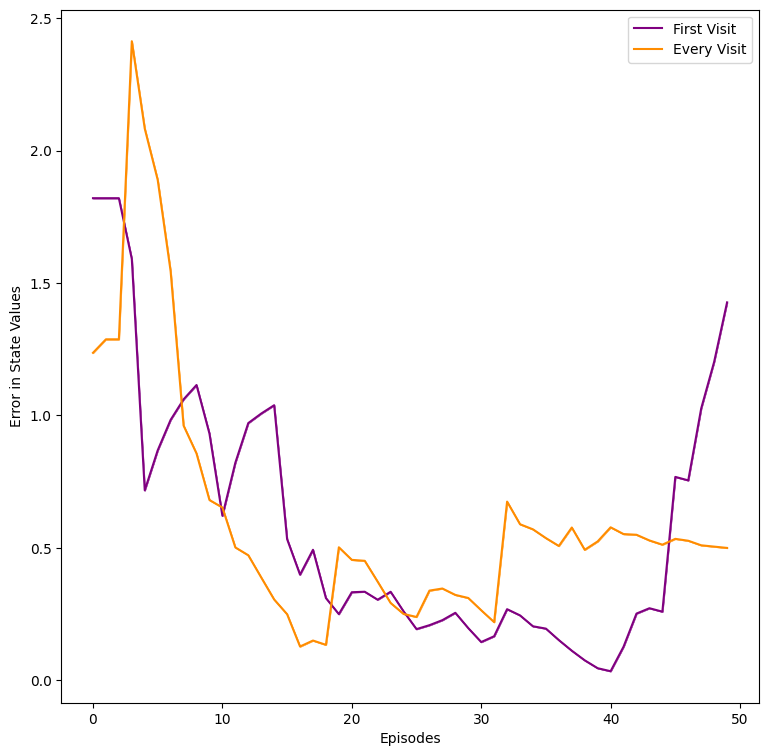

In [191]:
# Do not change the contents of this cell!
# (There are TODO comments but they are for later...)

trueV = {'S1': 2.237835524546828, 'S2': 1.7284565203872646}

numTrials = 500
numEps = 50

errs = [[0]*numEps, [0]*numEps]
sqErrs = [[0]*numEps, [0]*numEps]
stdErr = [[0]*numEps, [0]*numEps]
everyVis = [False, True]
names = ["First Visit", "Every Visit"]
for alg in range(2):
  # TODO: Run each algorithm numTrials times
  vFuncs = []
  evaluatePolicyMC(m, eqPolicy, numEpisodes=numEps, values=vFuncs, everyVisit=everyVis[alg])
  for i in range(numEps):
    # For each episode, compute the root mean squared error
    stateErrs = [(trueV[s] - vFuncs[i][s])*(trueV[s] - vFuncs[i][s]) for s in trueV]
    err = math.sqrt(sum(stateErrs)/len(stateErrs))

    errs[alg][i] = err # TODO: this line probably has to change
    sqErrs[alg][i] = err*err # TODO: this line probably has to change
  #TODO: By this point errs[alg][i] should store the _average_ error
  #      over all trials for that algorithm and that episode.
  #      Similarly, sqErrs should have the average squared errors.

  # TODO: Now compute stdErr[alg][i] for each episode i



# Now we plot the results

Line = namedtuple("Line", "data, err, label, color")

def plot_avg_err(ax, lines):
  ax.set_xlabel("Episodes")
  ax.set_ylabel("Error in State Values")
  xs = range(len(lines[0].data))
  for line in lines:
    upper = [line.data[i] + line.err[i] for i in range(len(line.data))]
    lower = [line.data[i] - line.err[i] for i in range(len(line.data))]
    ax.fill_between(xs, upper, lower, color=line.color, alpha=0.5)
    ax.plot(xs, line.data, label=line.label, c=line.color)
  ax.legend(loc='upper right')

fig, ax = plt.subplots(1, figsize=(9, 9))
plot_avg_err(ax, [Line(errs[0], stdErr[0], names[0], 'purple'),
                  Line(errs[1], stdErr[1], names[1], 'darkorange')])
plt.show()

The curves you get will probably be pretty spikey.

* Now try running the snippet multiple times.

You will get wildly differing results!

The problem is that there is a lot of randomness in this process, both in how actions are selected and in how the environment responds. Different runs of the same algorithm could go very differently!

## Experimental Methodology: Averaging Multiple Independent Trials

In order to draw any reliable conclusions about randomized outcomes, we have to **average out the noise.** We do this by running the same algorithm many times and averaging the results. We can also measure the standard deviation of the results. That way we get a sense of its _typical_ performance.

In the cell below, you'll write a new version of the above code with the following changes:
* Each algorithm (First-Visit and Every-Visit) should be run `numTrials` times.
* By the end, `err[alg][i]` should be the _average_ error in episode `i` for algorithm `alg` over all of the independent trials. Similarly `sqErrs[alg][i]` should be the _average_ of the squared errors.
* `stdErr[alg][i]` will have the standard error of the collected value errors for each algorithm and episode.

You should use the alternate formula for the sample variance to calculate the standard error:
$$\widehat{\sigma}^2 = \frac{n}{n-1}*\left(\text{avg}\left(x^2\right) - \text{avg}(x)^2\right)$$
$$SE = \sqrt{\frac{\widehat{\sigma}^2}{n}}$$

Once you've done that, the plot will show the average and standard error over 500 independent runs of the algorithms.

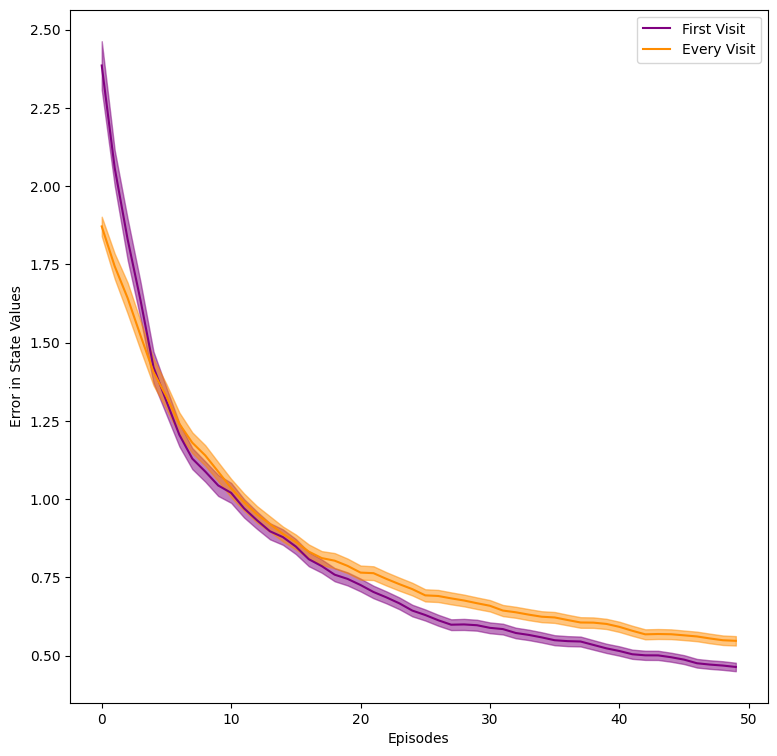

In [192]:
# Do not change the contents of this cell!
# (There are TODO comments but they are for later...)

trueV = {'S1': 2.237835524546828, 'S2': 1.7284565203872646}

numTrials = 500
numEps = 50

errs = [[0]*numEps, [0]*numEps]
sqErrs = [[0]*numEps, [0]*numEps]
stdErr = [[0]*numEps, [0]*numEps]
everyVis = [False, True]
names = ["First Visit", "Every Visit"]
for alg in range(2):
  # TODO: Run each algorithm numTrials times
  for _ in range(numTrials):
    vFuncs = []
    evaluatePolicyMC(m, eqPolicy, numEpisodes=numEps, values=vFuncs, everyVisit=everyVis[alg])
    for i in range(numEps):
      # For each episode, compute the root mean squared error
      stateErrs = [(trueV[s] - vFuncs[i][s])*(trueV[s] - vFuncs[i][s]) for s in trueV]
      err = math.sqrt(sum(stateErrs)/len(stateErrs))
      errs[alg][i] += err # Average error in episode i for algorithm alg over all the trials
      sqErrs[alg][i] += (err*err) # average of the squared errors
    #TODO: By this point errs[alg][i] should store the _average_ error
    #      over all trials for that algorithm and that episode.
    #      Similarly, sqErrs should have the average squared errors.

    # TODO: Now compute stdErr[alg][i] for each episode i
  for i in range(numEps):
    errs[alg][i] = errs[alg][i] / numTrials
    sqErrs[alg][i] = sqErrs[alg][i] / numTrials
  for i in range(numEps):
    # stdErr[alg][i] = math.sqrt((sqErrs[alg][i] - ((1/numTrials)*(errs[alg][i]*errs[alg][i])))/(denom))
    difference = sqErrs[alg][i] - errs[alg][i]*errs[alg][i]
    difference = difference / (numTrials-1)
    stdErr[alg][i] = math.sqrt(difference)



# Now we plot the results

Line = namedtuple("Line", "data, err, label, color")

def plot_avg_err(ax, lines):
  ax.set_xlabel("Episodes")
  ax.set_ylabel("Error in State Values")
  xs = range(len(lines[0].data))
  for line in lines:
    upper = [line.data[i] + line.err[i] for i in range(len(line.data))]
    lower = [line.data[i] - line.err[i] for i in range(len(line.data))]
    ax.fill_between(xs, upper, lower, color=line.color, alpha=0.5)
    ax.plot(xs, line.data, label=line.label, c=line.color)
  ax.legend(loc='upper right')

fig, ax = plt.subplots(1, figsize=(9, 9))
plot_avg_err(ax, [Line(errs[0], stdErr[0], names[0], 'purple'),
                  Line(errs[1], stdErr[1], names[1], 'darkorange')])
plt.show()

You should now clearly see that:

* Every-visit MC performs better at first (on average), decreasing its error faster.
    * That makes sense. Every-visit MC performs more updates!
* First-visit MC eventually catches up and does better long-term (on average).
    * This makes sense too. Every-visit MC averages non-independent samples, which adds bias to the estimate.
    * Every-visit MC will converge to the correct values, but it will take longer to overcome the bias.

Furthermore, this finding should be reproducible if you run the cell multiple times.

Your plot should look similar to the one below (though not exactly the same).

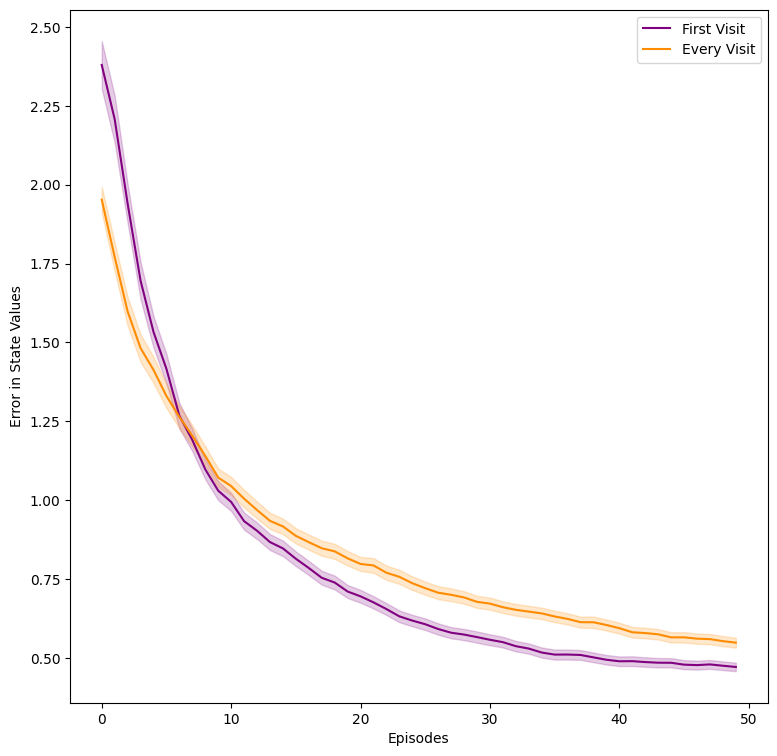

# TODO: Submit!

1. Make sure that the output of all cells is up-to-date (easiest way is to choose _Runtime/Run all_).
2. If you are working in Colab, choose _File/Download/Download .ipnb_ (otherwise locate your _.ipnb_ file)
3. Go to the [Gradescope assignment](https://www.gradescope.com/courses/1083624/assignments/6790736) to submit.
4. Choose _Upload_ as the submission method and upload your _.ipnb_ file.
5. If you are working as a pair, make sure to push the _Group Members_ button to add the other partner.